## Importing Libraries

In [3]:
from PIL import Image
from collections import namedtuple

import os
import glob
import pickle
import time
import numpy as np

from typing import *

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt 

## Integral Image

In [31]:
## Calculating integral image
def calculate_integral_image(array):
    s = np.zeros(array.shape)
    ii = np.zeros(array.shape)
    for x in range(array.shape[0]):
        for y in range(0,array.shape[1]):
            s[x,y] = s[x,y-1] + array[x,y] if y>0 else array[x,y]
            ii[x,y] = ii[x-1,y] + s[x,y] if x>0 else s[x,y]
    return np.pad(ii, (1, 1), 'constant', constant_values=(0, 0))[:-1, :-1]

## Haar Features 

In [32]:
Feature = namedtuple('Feature', 'name x y width height pos_x pos_y kernel')

## Two rectangles placed horizontally 
def feature_2h(x, y, width, height):
    pos_x = [x, x+width, x, x+width,
                x, x+width, x, x+width]
    pos_y = [y, y, y+height, y+height,
                y+height, y+height, y+2*height, y+2*height]
    kernel = [1, -1, -1, 1,
              -1, 1, 1, -1]
    return Feature('Two Horizontal Features', x, y, width, 2*height, pos_x, pos_y, kernel)


## Three rectangles placed horizontally 
def feature_3h(x, y, width, height):
    pos_x = [x, x+width, x, x+width,
                x, x+width, x, x+width,
                x, x+width, x, x+width]
    pos_y = [y, y, y+height, y+height,
                y+height, y+height, y+2*height, y+2*height,
                y+2*height, y+2*height, y+3*height, y+3*height]
    kernel = [-1, 1, 1, -1,
               1, -1, -1, 1,
              -1, 1, 1, -1]
    return Feature('Three Horizontal Features', x, y, width, 3*height, pos_x, pos_y, kernel)


## Two rectangles placed vertically 
def feature_2v(x, y, width, height):
    pos_x = [x, x+width, x, x+width,
                x+width, x+2*width, x+width, x+2*width]
    pos_y = [y, y, y+height, y+height,
               y, y, y+height, y+height]
    kernel = [-1, 1, 1, -1,
             1, -1, -1, 1]
    return Feature('Two Vertical Features', x, y, 2*width, height, pos_x, pos_y, kernel)


## Three rectangles placed vertically 
def feature_3v(x, y, width, height):
    pos_x = [x, x+width, x, x+width,
                x+width, x+2*width, x+width, x+2*width,
                x+2*width, x+3*width, x+2*width, x+3*width]
    pos_y = [y, y, y+height, y+height,
                y, y, y+height, y+height,
                y, y, y+height, y+height]
    kernel = [-1, 1, 1, -1,
               1, -1, -1, 1,
              -1, 1, 1, -1]
    return Feature('Three Vertical Features', x, y, 3*width, height, pos_x, pos_y, kernel)


## Four rectangles placed diagonally 
def feature_4d(x, y, width, height):
    pos_x = [x, x+width, x, x+width,
                x+width, x+2*width, x+width, x+2*width,
                x, x+width, x, x+width,
                x+width, x+2*width, x+width, x+2*width]
    pos_y = [y, y, y+height, y+height,
                y, y, y+height, y+height,
                y+height, y+height, y+2*height, y+2*height,
                y+height, y+height, y+2*height, y+2*height]
    kernel = [-1, 1, 1, -1,
               1, -1, -1, 1,
               1, -1, -1, 1,
              -1, 1, 1, -1]
    return Feature('Four Diagonal Features', x, y, 2*width, 2*height, pos_x, pos_y, kernel)

In [33]:
Feature = namedtuple('Feature', 'name x y width height pos_x pos_y kernel')

In [34]:
###### Finding shapes and positions of different haar features
def get_all_features(image_shape):
        height, width = image_shape
        features = [[],[],[],[],[]]
        names = ['Two Vertical Features', 'Two Horizontal Features', 'Three Vertical Features', 'Three Horizontal Features', 'Four Diagonal Features']
        for i in range(width):
            for j in range(height):
                for w in range(1, width+1):
                    for h in range(1, height+1):
                        if i + w < width and j + h < height:
                            if j + 2 * h < height:
                                features[0].append(feature_2h(i, j, w, h))
                            if i + 2 * w < width: 
                                features[1].append(feature_2v(i, j, w, h))
                            if j + 3 * h < height: 
                                features[2].append(feature_3h(i, j, w, h))
                            if i + 3 * w < width:
                                features[3].append(feature_3v(i, j, w, h))
                            if i + 2 * w < width and j + 2 * h < height:
                                features[4].append(feature_4d(i, j, w, h))
        total_features = []
        for i,fn in enumerate(names):
            print('Feature %s with value: %d' % (names[i], len(features[i])))
            total_features.extend(features[i])
        print('Total Number of Features', len(total_features))
        return total_features

In [35]:
# get value of a given feature from the integral image
def compute_feature(image, feature):
    return np.sum(np.multiply(image[feature.pos_y, feature.pos_x], feature.kernel))

In [36]:
input_image = Image.open('Dataset/trainset/faces/face00001.png')
input_integral = calculate_integral_image( np.array(input_image))
total_features = get_all_features(input_integral.shape)

Feature Two Vertical Features with value: 17100
Feature Two Horizontal Features with value: 17100
Feature Three Vertical Features with value: 10830
Feature Three Horizontal Features with value: 10830
Feature Four Diagonal Features with value: 8100
Total Number of Features 63960


## Dataloaders

### Extracting the train files which is of shape (Number of features * number of images) and the integral files for both test and train which is of shape (size of integral * number of images)

In [7]:
def image_to_array(img):
    return np.array(img)
def array_to_image(values):
    return Image.fromarray(values)

In [8]:
if not (os.path.exists('data_train-X_integrals') 
        and os.path.exists('data_train-X') 
        and os.path.exists('data_train-Y')):
    train_X_integrals = []
    train_X = []
    train_Y = []

    faces_dir = "Dataset/trainset/faces/"
    face_files = glob.glob(os.path.join(faces_dir, '*.png'))
    print('Number of Training face files is:',len(face_files))

    non_faces_dir = "Dataset/trainset/non-faces/"
    non_faces_files = glob.glob(os.path.join(non_faces_dir, '*.png'))
    print('Number of Training non-face files is:',len(non_faces_files))


    for f in face_files:
        x = image_to_array(Image.open(f))
        integral= calculate_integral_image(x)
        # compute all feature values for this image
        feature_values = []
        for f in total_features:
            feature_values.append(compute_feature(integral, f))
        train_X_integrals.append(integral)
        train_X.append(feature_values)
        train_Y.append(1.0)

    for f in non_faces_files:
        x = image_to_array(Image.open(f))
        integral= calculate_integral_image(x)
        # compute all feature values for this image
        feature_values = []
        for f in total_features:
            feature_values.append(compute_feature(integral, f))
        train_X_integrals.append(integral)
        train_X.append(feature_values)
        train_Y.append(0.0)

    train_X_integrals = np.array(train_X_integrals)
    train_X = np.array(train_X)
    train_Y = np.array(train_Y)
    print('Train samples feature value matrix shape is',train_X.shape)
    train_X_integrals.dump('data_train-X_integrals')                              
    train_X.dump('data_train-X')
    train_Y.dump('data_train-Y')

In [87]:
if not (os.path.exists('data_test-X_integrals')
        and os.path.exists('data_test-Y')):
    test_X_integrals = []
    test_Y = []

    faces_test_dir = "Dataset/testset/faces/"
    face_test_files = glob.glob(os.path.join(faces_test_dir, '*.png'))
    print('Number of Testing face files is:',len(face_test_files))

    non_faces_test_directory = "Dataset/testset/non-faces/"
    non_faces_test_files = glob.glob(os.path.join(non_faces_test_directory, '*.png'))
    print('Number of Testing non-face files is:',len(non_faces_test_files))


    for f in face_test_files:
        x = image_to_array(Image.open(f))
        integral= calculate_integral_image(x)
        test_X_integrals.append(integral)
        test_Y.append(1.0)

    for f in non_faces_test_files:
        x = image_to_array(Image.open(f))
        integral= calculate_integral_image(x)
        test_X_integrals.append(integral)
        test_Y.append(0.0)

    test_X_integrals = np.array(test_X_integrals)
    test_Y = np.array(test_Y)
    # print('Test samples feature value matrix shape is',test_X.shape)
    test_X_integrals.dump('data_test-X_integrals')
    test_Y.dump('data_test-Y')

Number of Testing face files is: 472
Number of Testing non-face files is: 19572


In [7]:
ClassifierResult = namedtuple('ClassifierResult', 'feature position polarity threshold classification_error')
WeakClassifier = namedtuple('WeakClassifier', 'polarity threshold alpha classifier position')

In [16]:
train_X = pickle.load(open("data_train-X", "rb"))
train_Y = pickle.load(open("data_train-Y", "rb"))

In [12]:
print(train_X.shape, train_Y.shape)

(2499, 63960) (2499,)


In [23]:
def ada_boost_train(train_X, train_Y, rounds, features, weights=None):
    if weights is None:
        weights = initialize_weights(train_Y)

    weak_classifiers = []
    for t in range(rounds):
        start_time = time.time()
        print('Weak classifier Round', t+1)
        weights = weights / weights.sum()
        # best weak classifier for this round
        classifier, weights = get_best_wk_classified(train_X, train_Y, weights, features)
        weak_classifiers.append(classifier)
        if (t+1) in [1, 3, 5, 10]:
            with open("wk_"+str(t+1)+".pkl", 'wb') as f:
                pickle.dump(weak_classifiers, f)
        time_now = time.time()
        print()
        print('Time taken', (time_now - start_time))
    return weak_classifiers

In [14]:
def get_best_wk_classified(train_X, train_Y, weights, features):
    best_wk = ClassifierResult(feature=None, position=0, polarity=0, threshold=0, classification_error=float('inf'))
    processed = 1
    print('Completed: ')
    for i,f in enumerate(features):
        result = classify_wk(f, i, train_X[:,i], train_Y, weights)
        if result.classification_error < best_wk.classification_error:
            best_wk = result
        processed += 1
        if processed % 5000 == 0:
            print(processed, end=' ')
    beta = best_wk.classification_error / (1 - best_wk.classification_error)
    alpha = np.log(1. / beta)
    classifier = WeakClassifier(threshold=best_wk.threshold, 
                                polarity=best_wk.polarity, 
                                classifier=best_wk.feature, 
                                position=best_wk.position, 
                                alpha=alpha)
    for i, (fx, y) in enumerate(zip(train_X[:,classifier.position], train_Y)):
        h = weak_classifier(fx, classifier.polarity, classifier.threshold)
        e = np.abs(h - y)
        weights[i] = weights[i] * np.power(beta, 1-e)
    return classifier, weights

In [15]:
def initialize_weights(train_Y):
    faces = len(train_Y[train_Y > 0.5])
    non_faces = len(train_Y[train_Y < 0.5])

    weights = np.zeros(train_Y.shape)
    weights[train_Y > 0.5] = 1.0/(2*faces)
    weights[train_Y < 0.5] = 1.0/(2*non_faces)
    return weights

In [16]:
def classify_wk(feature, position, train_fX, train_Y, weights):
    threshold, polarity = determine_threshold_polarity(train_fX, train_Y, weights)
    # Determine the classification error
    error = 0.0
    for fx, y, w in zip(train_fX, train_Y, weights):
        h = weak_classifier(fx, polarity, threshold)
        error += w * np.abs(h - y)
    return ClassifierResult(threshold=threshold, polarity=polarity, 
                            classification_error=error, feature=feature, position=position)

In [17]:
def determine_threshold_polarity(data_y, weights, feature_val) :  
    index = np.argsort(feature_val)
    feature_val= feature_val[index]
    data_y= data_y[index]
    weights= weights[index]
    total_minus, total_plus, running_minuses, running_pluses = calculate_running_sum(data_y, weights)
    return best_feature_threshold(feature_val, total_minus, total_plus, running_minuses, running_pluses)

In [18]:
def best_feature_threshold(feature_val, total_minus, total_plus, running_minuses, running_pluses):
    min_thresh, polarity = 0, 0
    min_e = float('inf')
    for thres, e_m, e_p in zip(feature_val, running_minuses, running_pluses):
        error_p = e_p + (total_minus - e_m)
        error_m = e_m + (total_plus - e_p)
        if error_p < min_e:
            min_e = error_p
            polarity = -1
            min_thresh = thres

        elif error_m < min_e:
            min_e = error_m
            polarity = 1
            min_thresh = thres

    return min_thresh, polarity

In [19]:
def calculate_running_sum(data_y, weights):
    running_minus, running_plus = 0.0, 0.0
    total_minus, total_plus = 0.0, 0.0
    running_minuses,  running_pluses = [], []
    for output, weight in zip(data_y, weights):
        if output > 0.5:
            running_plus += weight
            total_plus += weight
        else:
            running_minus += weight
            total_minus += weight
        running_minuses.append(running_minus)
        running_pluses.append(running_plus)
    return total_minus, total_plus, running_minuses, running_pluses

In [24]:
def weak_classifier(fx, polarity, threshold):
    ## as per definition of weak classifier
    if(polarity * fx) < (polarity*threshold): 
        return 1
    return 0

## Training for different rounds 

In [21]:
def train(rounds):
    if not os.path.exists("wk_"+str(rounds)+".pkl"):
        print('Training Started')
        wk = ada_boost_train(train_X, train_Y, rounds, total_features)
        with open("wk_"+str(rounds)+".pkl", 'wb') as f:
            pickle.dump(wk, f)
    else:
        wk = pickle.load(open("wk_"+str(rounds)+".pkl", "rb"))
    return wk

In [24]:
wk_10 = train(10)
print(wk_10)

Training Started
Weak classifier Round 1
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 646.8602104187012
Weak classifier Round 2
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 691.7556002140045
Weak classifier Round 3
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 665.6745843887329
Weak classifier Round 4
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 647.2083048820496
Weak classifier Round 5
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 652.1994569301605
Weak classifier Round 6
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 652.126222372055
Weak classifier Round 7
Completed: 
5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 
Time taken 652.2994260787964
Weak classifier Round 8
C

In [25]:
wk_1 = train(1)
print(wk_1)

[WeakClassifier(polarity=-1, threshold=0.00025, alpha=1.2165390200872, classifier=Feature(name='Two Vertical Features', x=7, y=6, width=12, height=10, pos_x=[7, 13, 7, 13, 13, 19, 13, 19], pos_y=[6, 6, 16, 16, 6, 6, 16, 16], kernel=[-1, 1, 1, -1, 1, -1, -1, 1]), position=28028)]


In [26]:
wk_3 = train(3)
print(wk_3)

[WeakClassifier(polarity=-1, threshold=0.00025, alpha=1.2165390200872, classifier=Feature(name='Two Vertical Features', x=7, y=6, width=12, height=10, pos_x=[7, 13, 7, 13, 13, 19, 13, 19], pos_y=[6, 6, 16, 16, 6, 6, 16, 16], kernel=[-1, 1, 1, -1, 1, -1, -1, 1]), position=28028), WeakClassifier(polarity=1, threshold=0.00016203171535411243, alpha=0.9550542896694941, classifier=Feature(name='Two Horizontal Features', x=5, y=14, width=2, height=4, pos_x=[5, 7, 5, 7, 5, 7, 5, 7], pos_y=[14, 14, 16, 16, 16, 16, 18, 18], kernel=[1, -1, -1, 1, -1, 1, 1, -1]), position=8829), WeakClassifier(polarity=-1, threshold=0.0015178189805250537, alpha=0.8468125295076965, classifier=Feature(name='Three Vertical Features', x=5, y=2, width=9, height=1, pos_x=[5, 8, 5, 8, 8, 11, 8, 11, 11, 14, 11, 14], pos_y=[2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3], kernel=[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1]), position=50342)]


In [27]:
wk_5 = train(5)
print(wk_5)

[WeakClassifier(polarity=-1, threshold=0.00025, alpha=1.2165390200872, classifier=Feature(name='Two Vertical Features', x=7, y=6, width=12, height=10, pos_x=[7, 13, 7, 13, 13, 19, 13, 19], pos_y=[6, 6, 16, 16, 6, 6, 16, 16], kernel=[-1, 1, 1, -1, 1, -1, -1, 1]), position=28028), WeakClassifier(polarity=1, threshold=0.00016203171535411243, alpha=0.9550542896694941, classifier=Feature(name='Two Horizontal Features', x=5, y=14, width=2, height=4, pos_x=[5, 7, 5, 7, 5, 7, 5, 7], pos_y=[14, 14, 16, 16, 16, 16, 18, 18], kernel=[1, -1, -1, 1, -1, 1, 1, -1]), position=8829), WeakClassifier(polarity=-1, threshold=0.0015178189805250537, alpha=0.8468125295076965, classifier=Feature(name='Three Vertical Features', x=5, y=2, width=9, height=1, pos_x=[5, 8, 5, 8, 8, 11, 8, 11, 11, 14, 11, 14], pos_y=[2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3], kernel=[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1]), position=50342), WeakClassifier(polarity=1, threshold=0.0003212321496803557, alpha=0.9754101903105783, classifier

## Evaluating Performance for different rounds using Combined Classifier

In [26]:
def get_feature(x, index):
    return compute_feature(x, total_features[index])

In [48]:
def combined_classifier(x, weak_classifiers):
    lhs = 0.0
    rhs = 0.0
    for wc in weak_classifiers:
        lhs += wc.alpha * weak_classifier(get_feature(x, wc.position), wc.polarity, wc.threshold)
        rhs += wc.alpha
    if lhs >= 0.5*rhs:  ## as per definition of strong classifier
        return 1
    else:
        return 0

In [21]:
train_X_integrals = pickle.load( open( "data_train-X_integrals", "rb" ) )
train_Y = pickle.load( open( "data_train-Y", "rb" ) )

In [22]:
test_X_integrals = pickle.load( open( "data_test-X_integrals", "rb" ) )
test_Y = pickle.load( open( "data_test-Y", "rb" ) )

In [90]:
def evaluate_performance(data_X, data_Y, weak_classifiers):
    y_predicted = []
    for x in data_X:
        y_predicted.append(combined_classifier(x, weak_classifiers))
    return performance(data_Y,y_predicted)

In [91]:
def performance(data_test_y, y_predicted):
    tn, fp, fn, tp = confusion_matrix(data_test_y, y_predicted).ravel()
    acc = accuracy_score(data_test_y, y_predicted)
    fpr = fp/(fp+tn)
    fnr = fn/(tp+fn)
    return acc, fpr, fnr

In [92]:
for t in [1,3,5,10]:
    print('Performance for round: ',t)
    op = pickle.load( open( "weak_classifiers_t"+str(t)+".pkl", "rb" ) )
    print('On train(ACC, FPR and FNR) :', evaluate_performance(train_X_integrals, train_Y, op))
    print('On test(ACC, FPR and FNR) :',evaluate_performance(test_X_integrals, test_Y, op))

Performance for round:  1
On train(ACC, FPR and FNR) : (0.6618647458983593, 0.411, 0.04609218436873747)
On test(ACC, FPR and FNR) : (0.42686090600678506, 0.5781218066625792, 0.3665254237288136)
Performance for round:  3
On train(ACC, FPR and FNR) : (0.8231292517006803, 0.173, 0.19238476953907815)
On test(ACC, FPR and FNR) : (0.7011075633606066, 0.2876047414674024, 0.7669491525423728)
Performance for round:  5
On train(ACC, FPR and FNR) : (0.8355342136854742, 0.1965, 0.036072144288577156)
On test(ACC, FPR and FNR) : (0.664587906605468, 0.32515838953607196, 0.760593220338983)
Performance for round:  10
On train(ACC, FPR and FNR) : (0.9003601440576231, 0.124, 0.002004008016032064)
On test(ACC, FPR and FNR) : (0.814508082219118, 0.17182709993868792, 0.7521186440677966)


## Visualize top 10 features

In [94]:
def image_display_2_horizontal(classify):
    test_image = "Dataset/testset/faces/cmu_0001.png"
    Image.open(test_image).resize((100,100))
    test_image_array = image_to_array(Image.open(test_image))
    x = classify.classifier.x
    y = classify.classifier.y
    width = classify.classifier.width
    height = classify.classifier.height
    test_image_array[y:y+height//2, x:x+width] = 255
    test_image_array[y+height//2:y+height, x:x+width] = 0
    return (array_to_image(test_image_array))

In [95]:
def image_display_2_vertical(classify):
    test_image = "Dataset/testset/faces/cmu_0001.png"
    Image.open(test_image).resize((100,100))
    test_image_array = image_to_array(Image.open(test_image))
    x = classify.classifier.x
    y = classify.classifier.y
    width = classify.classifier.width
    height = classify.classifier.height
    test_image_array[y:y+height, x:x+width//2] = 0
    test_image_array[y:y+height, x+width//2:x+width] = 255
    return (array_to_image(test_image_array))

In [96]:
def image_display_3_vertical(classify):
    test_image = "Dataset/testset/faces/cmu_0001.png"
    Image.open(test_image).resize((100,100))
    test_image_array = image_to_array(Image.open(test_image))
    x = classify.classifier.x
    y = classify.classifier.y
    width = classify.classifier.width
    height = classify.classifier.height
    test_image_array[y:y+height, x:x+width//3] = 0
    test_image_array[y:y+height, x+width//3:x+(2*width)//3] = 255
    test_image_array[y:y+height, x+(2*width)//3:x+width] = 0
    return (array_to_image(test_image_array))

In [97]:
def image_display_3_horizontal(classify):
    test_image = "Dataset/testset/faces/cmu_0001.png"
    Image.open(test_image).resize((100,100))
    test_image_array = image_to_array(Image.open(test_image))
    x = classify.classifier.x
    y = classify.classifier.y
    width = classify.classifier.width
    height = classify.classifier.height
    test_image_array[y:y+height//3, x:x+width] = 255
    test_image_array[y+height//3:y+(2*height)//3, x:x+width] = 0
    test_image_array[y+(2*height)//3:y+height, x:x+width] = 255
    return (array_to_image(test_image_array))

In [98]:
def image_display_4_diagonal(classify):
    test_image = "Dataset/testset/faces/cmu_0001.png"
    Image.open(test_image).resize((100,100))
    test_image_array = image_to_array(Image.open(test_image))
    x = classify.classifier.x
    y = classify.classifier.y
    width = classify.classifier.width
    height = classify.classifier.height
    test_image_array[y:y+height//2, x:x+width//2] = 255
    test_image_array[y:y+height//2, x+width//2:x+width] = 0
    test_image_array[y+height//2:y+height, x:x+width//2] = 0
    test_image_array[y+height//2:y+height, x+width//2:x+width] = 255
    return (array_to_image(test_image_array))

In [99]:
clf= pickle.load( open( "wk_10.pkl", "rb" ) )

In [100]:
for t in range(10):
    if clf[t].classifier.name =='Two Horizontal Features':
        image = image_display_2_horizontal(clf[t]).resize((200,200))
    elif clf[t].classifier.name =='Two Vertical Features':
        image =image_display_2_vertical(clf[t]).resize((200,200))
    elif clf[t].classifier.name =='Three Horizontal Features':
        image =image_display_3_horizontal(clf[t]).resize((200,200))
    elif clf[t].classifier.name =='Three Vertical Features':
        image =image_display_3_vertical(clf[t]).resize((200,200))
    elif clf[t].classifier.name =='Four Diagonal Features':
        image =image_display_4_diagonal(clf[t]).resize((200,200))
    image.save(str(t)+".png")


WeakClassifier(polarity=-1, threshold=0.00025, alpha=1.2165390200872, classifier=Feature(name='Two Vertical Features', x=7, y=6, width=12, height=10, pos_x=[7, 13, 7, 13, 13, 19, 13, 19], pos_y=[6, 6, 16, 16, 6, 6, 16, 16], kernel=[-1, 1, 1, -1, 1, -1, -1, 1]), position=28028)


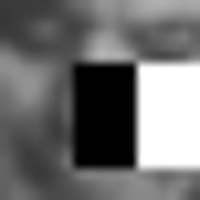

In [102]:
print(clf[0])
Image.open(str(0)+".png")

WeakClassifier(polarity=1, threshold=0.00016203171535411243, alpha=0.9550542896694941, classifier=Feature(name='Two Horizontal Features', x=5, y=14, width=2, height=4, pos_x=[5, 7, 5, 7, 5, 7, 5, 7], pos_y=[14, 14, 16, 16, 16, 16, 18, 18], kernel=[1, -1, -1, 1, -1, 1, 1, -1]), position=8829)


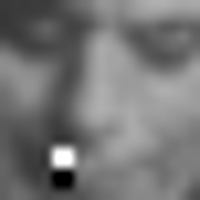

In [103]:
print(clf[1])
Image.open(str(1)+".png")

WeakClassifier(polarity=-1, threshold=0.0015178189805250537, alpha=0.8468125295076965, classifier=Feature(name='Three Vertical Features', x=5, y=2, width=9, height=1, pos_x=[5, 8, 5, 8, 8, 11, 8, 11, 11, 14, 11, 14], pos_y=[2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3], kernel=[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1]), position=50342)


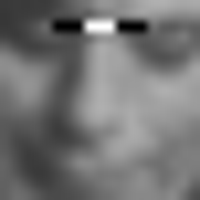

In [104]:
print(clf[2])
Image.open(str(2)+".png")

WeakClassifier(polarity=1, threshold=0.0003212321496803557, alpha=0.9754101903105783, classifier=Feature(name='Two Vertical Features', x=6, y=5, width=2, height=8, pos_x=[6, 7, 6, 7, 7, 8, 7, 8], pos_y=[5, 5, 13, 13, 5, 5, 13, 13], kernel=[-1, 1, 1, -1, 1, -1, -1, 1]), position=26737)


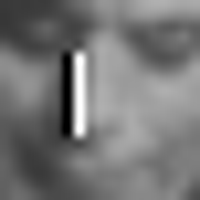

In [105]:
print(clf[3])
Image.open(str(3)+".png")

WeakClassifier(polarity=-1, threshold=5.518300895819468e-05, alpha=0.7989871114474525, classifier=Feature(name='Two Horizontal Features', x=16, y=17, width=1, height=2, pos_x=[16, 17, 16, 17, 16, 17, 16, 17], pos_y=[17, 17, 18, 18, 18, 18, 19, 19], kernel=[1, -1, -1, 1, -1, 1, 1, -1]), position=16827)


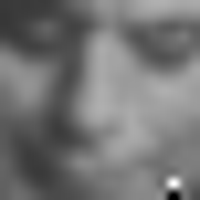

In [106]:
print(clf[4])
Image.open(str(4)+".png")

WeakClassifier(polarity=-1, threshold=0.0025772960530449788, alpha=0.8088189201722504, classifier=Feature(name='Three Horizontal Features', x=2, y=0, width=1, height=9, pos_x=[2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3], pos_y=[0, 0, 3, 3, 3, 3, 6, 6, 6, 6, 9, 9], kernel=[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1]), position=36311)


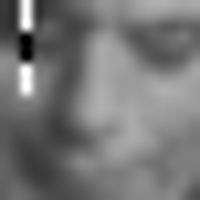

In [107]:
print(clf[5])
Image.open(str(5)+".png")

WeakClassifier(polarity=-1, threshold=2.8908926348530014e-05, alpha=1.039133259167919, classifier=Feature(name='Two Vertical Features', x=7, y=10, width=2, height=7, pos_x=[7, 8, 7, 8, 8, 9, 8, 9], pos_y=[10, 10, 17, 17, 10, 10, 17, 17], kernel=[-1, 1, 1, -1, 1, -1, -1, 1]), position=28236)


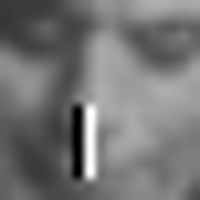

In [108]:
print(clf[6])
Image.open(str(6)+".png")

WeakClassifier(polarity=1, threshold=1.9567890954909006e-05, alpha=0.681364475517381, classifier=Feature(name='Two Vertical Features', x=9, y=9, width=4, height=1, pos_x=[9, 11, 9, 11, 11, 13, 11, 13], pos_y=[9, 9, 10, 10, 9, 9, 10, 10], kernel=[-1, 1, 1, -1, 1, -1, -1, 1]), position=30135)


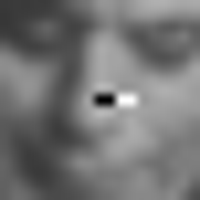

In [109]:
print(clf[7])
Image.open(str(7)+".png")

WeakClassifier(polarity=-1, threshold=0.002271660430895496, alpha=0.9789010415239648, classifier=Feature(name='Three Horizontal Features', x=15, y=1, width=1, height=3, pos_x=[15, 16, 15, 16, 15, 16, 15, 16, 15, 16, 15, 16], pos_y=[1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4], kernel=[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1]), position=44484)


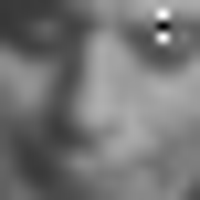

In [110]:
print(clf[8])
Image.open(str(8)+".png")

WeakClassifier(polarity=-1, threshold=1.0134888145490722e-05, alpha=0.9847600535542508, classifier=Feature(name='Four Diagonal Features', x=8, y=3, width=2, height=14, pos_x=[8, 9, 8, 9, 9, 10, 9, 10, 8, 9, 8, 9, 9, 10, 9, 10], pos_y=[3, 3, 10, 10, 3, 3, 10, 10, 10, 10, 17, 17, 10, 10, 17, 17], kernel=[-1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1]), position=61396)


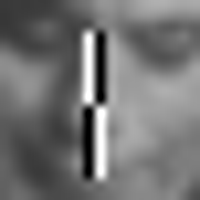

In [112]:
print(clf[9])
Image.open(str(9)+".png")

## ROC obtained by using different threshold values

Performance for round:  1
rounds1


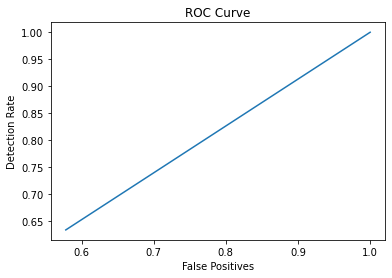

Performance for round:  3
rounds3


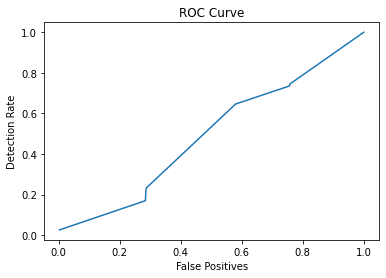

Performance for round:  5
rounds5


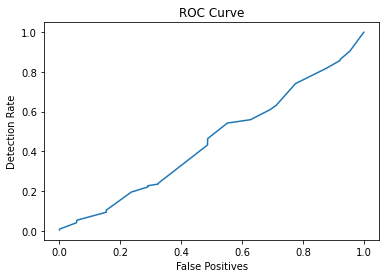

Performance for round:  10
rounds10


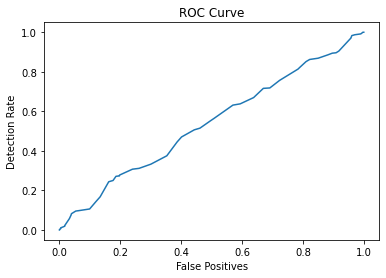

In [93]:
def roc_curve(data_X, test_Y, weak_classifiers):
    X = []
    y = []
    total_faces_count = (test_Y == 1).sum()
    for threshold in np.arange(0, 1.01, 0.01): 
        y_predicted = []
        for x in data_X:
            lhs = 0.0
            rhs = 0.0
            for wc in weak_classifiers:
                lhs += wc.alpha * weak_classifier(get_feature(x, wc.position), wc.polarity, wc.threshold)
                rhs += wc.alpha
            if lhs >= threshold*rhs:  ## as per definition of strong classifier
                y_predicted.append(1)
            else:
                y_predicted.append(0)
        tn, fp, fn, tp = confusion_matrix(test_Y, y_predicted).ravel()
        acc = accuracy_score(test_Y, y_predicted)
        TPR = tp / (tp + fn)
        FPR = fp / (fp + tn)
        X.append(FPR)
        y.append(TPR)
    plt.plot(X, y)
    plt.xlabel("False Positive rate")
    plt.ylabel("Detection Rate")
    plt.title("ROC Curve")
    plt.show()  


for t in [1,3,5,10]:
    print('Performance for round: ',t)
    op = pickle.load( open( "wk_"+str(t)+".pkl", "rb" ) )
    print("rounds" + str(t))
    roc_curve(test_X_integrals, test_Y, op)


In [ ]:
print('Training Started')
cascaded_classifier = adaboostTrain(train_X, train_Y, 25, total_features)
with open('cascade.pkl', 'wb') as f:
        pickle.dump(cascaded_classifier, f)

In [44]:
def cascade_train(data, labels, weak_classifiers):
    non_faces = []
    for i in range(len(data)): 
        if labels[i] != 1:
            non_faces.append(i)
    prev = len(non_faces)
    skip = 0
    for index, rounds in enumerate(layers):
        if len(non_faces) == 0:
            print("Stop cascade early")
            break
        
        false_positives = []
        for ex in non_faces:
            total = 0
            lhs = 0
            rhs = 0
#             print(skip,skip+rounds)
            for j in range(skip,skip+rounds):
                wc = weak_classifiers[j]
                lhs += wc.alpha * weak_classifier(get_feature(data[ex], wc.position), wc.polarity, wc.threshold)
                rhs += wc.alpha
            if lhs >= 0.5*rhs:  ## as per definition of strong classifier
                pred = 1
            else:
                pred = 0
            if pred == 1:
                false_positives.append(ex)
        non_faces = false_positives
        print('Layer ' + str(index + 1) + ': classifier with ' + str(rounds) + ' rounds')
        print('Number of non-face images discarded: ', prev-len(non_faces))
        prev = len(non_faces)
        skip += rounds
    return prev


In [45]:
# layers = [5, 5, 5, 10]
# op_cascade = pickle.load( open( "weak_classifiers_t25.pkl", "rb" ) )

layers = [2, 2, 2, 3]
op_cascade = pickle.load( open( "wk_"+str(10)+".pkl", "rb" ) )

In [46]:
cascade_train(train_X_integrals, train_Y, op_cascade)

Layer 1: classifier with 2 rounds
Number of non-face images discarded:  1178
Layer 2: classifier with 2 rounds
Number of non-face images discarded:  455
Layer 3: classifier with 2 rounds
Number of non-face images discarded:  366
Layer 4: classifier with 3 rounds
Number of non-face images discarded:  1


0

In [47]:
def cascade_evaluate(data, labels, weak_classifiers):
    cur_data = []
    for i in range(len(data)):
        cur_data.append(i)
    correct = 0
    fp = 0
    fn = 0
    skip = 0
    for index, rounds in enumerate(layers):
        new_data = []
        for i in cur_data:
            total = 0
            lhs = 0
            rhs = 0
            for j in range(skip, skip+rounds):
                wc = weak_classifiers[j]
                alpha = wc.alpha
                lhs += wc.alpha * weak_classifier(get_feature(data[i], wc.position), wc.polarity, wc.threshold)
                rhs += wc.alpha
            if lhs >= 0.5*rhs:  ## as per definition of strong classifier
                pred = 1
            else:
                pred = 0
            if pred == 1:
                new_data.append(i)
            else:
                if labels[i]==1:
                    fn+=1
                else:
                    correct+=1
        cur_data = new_data
        skip += rounds
    fp = len(cur_data)
    return (correct, fp, fn)

In [48]:
correct, fp, fn = cascade_evaluate(train_X_integrals, train_Y, op_cascade)
f = (train_Y == 1).sum()
nf = (train_Y == 0).sum()
print('Cascade Classifier on Train data')
print('Training accuracy: %.2f (%d/%d)' % (correct/(f+nf), correct, f+nf))
print('False positive: %.2f (%d/%d)' % (fp/(f+nf), fp, (f+nf)))
print('False negative: %.2f (%d/%d)\n' % (fn/(f+nf), fn, (f+nf)))

Cascade Classifier on Train data
Training accuracy: 0.80 (2000/2499)
False positive: 0.00 (2/2499)
False negative: 0.20 (497/2499)



In [49]:
correct, fp, fn = cascade_evaluate(test_X_integrals, test_Y, op_cascade)
f = (test_Y == 1).sum()
nf = (test_Y == 0).sum()
print('Cascade Classifier on Test data')
print('Testing accuracy: %.2f (%d/%d)' % (correct/(f+nf), correct, (f+nf)))
print('False positive: %.2f (%d/%d)' % (fp/(f+nf), fp, (f+nf)))
print('False negative: %.2f (%d/%d)\n' % (fn/(f+nf), fn, (f+nf)))

Cascade Classifier on Test data
Testing accuracy: 0.98 (19568/20044)
False positive: 0.00 (4/20044)
False negative: 0.02 (472/20044)

